<a href="https://colab.research.google.com/github/AhrendsW/PySpark-ML-Regression/blob/main/RegressionPySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Baixar a biblioteca pyspark
!pip install pyspark -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


### [SparkSession](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.SparkSession.html)

O ponto de entrada para programar o Spark com a API Dataset e DataFrame.

Uma SparkSession pode ser utilizada para criar DataFrames, registrar DataFrames como tabelas, executar consultas SQL em tabelas, armazenar em cache e ler arquivos parquet. Para criar uma SparkSession, use o seguinte padrão de construtor:

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
            .master("local[*]") \
            .appName("Regressão com Spark") \
            .config("spark.some.config.option", "some-value") \
            .getOrCreate()

In [3]:
spark

**Carregamento dos Dados**

### Montando o drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dados = spark.read.json('/content/drive/MyDrive/curso-spark/regressão-spark/data/imoveis.json')
dados.show()

+--------------------+--------------------+
|               ident|             listing|
+--------------------+--------------------+
|{775564-BOJSMVON,...|{{Rio de Janeiro,...|
|{660895-AUENKNYY,...|{{Rio de Janeiro,...|
|{751522-JESYFEQL,...|{{Rio de Janeiro,...|
|{714052-GAAEWYKS,...|{{Rio de Janeiro,...|
|{568886-ZIBFOMCC,...|{{Rio de Janeiro,...|
|{526755-OBLTYTEN,...|{{Rio de Janeiro,...|
|{593569-CJLMNFGW,...|{{Rio de Janeiro,...|
|{989181-RYJOLMCU,...|{{Rio de Janeiro,...|
|{145372-EZKAKSWM,...|{{Rio de Janeiro,...|
|{792086-NWNQTDYL,...|{{Rio de Janeiro,...|
|{339622-MNZGLKTZ,...|{{Rio de Janeiro,...|
|{952338-SVULQMXR,...|{{Rio de Janeiro,...|
|{570439-LDICQOXZ,...|{{Rio de Janeiro,...|
|{684023-YTBNKLLO,...|{{Rio de Janeiro,...|
|{629412-VKUMMAVR,...|{{Rio de Janeiro,...|
|{041590-HMJIRKDX,...|{{Rio de Janeiro,...|
|{870098-XTRYJAGY,...|{{Rio de Janeiro,...|
|{951104-MACIAPIS,...|{{Rio de Janeiro,...|
|{375665-GHMFEZXX,...|{{Rio de Janeiro,...|
|{441711-LRTWHRUA,...|{{Rio de J

In [6]:
dados.show(truncate=False)

+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|ident                     |listing                                                                                                                                                          |
+--------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{775564-BOJSMVON, Website}|{{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}, {0, 0, 0, 1, 0, 62, 0, 0, 62}, {45000, {150, 0}}, {Outros, Residencial}}                       |
|{660895-AUENKNYY, Website}|{{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}, {1, 2, 0, 1, 0, 0, 0, 0, 44}, {45000, {120, 0}}, {Apartamento, Residencial}}                |
|{751522-JESYFEQL, Website}|{{Rio de Janeiro,

In [7]:
dados.count()

73615

## **Seleção de *Features***

In [8]:
dados.printSchema()

root
 |-- ident: struct (nullable = true)
 |    |-- customerID: string (nullable = true)
 |    |-- source: string (nullable = true)
 |-- listing: struct (nullable = true)
 |    |-- address: struct (nullable = true)
 |    |    |-- city: string (nullable = true)
 |    |    |-- location: struct (nullable = true)
 |    |    |    |-- lat: double (nullable = true)
 |    |    |    |-- lon: double (nullable = true)
 |    |    |-- neighborhood: string (nullable = true)
 |    |    |-- zone: string (nullable = true)
 |    |-- features: struct (nullable = true)
 |    |    |-- bathrooms: long (nullable = true)
 |    |    |-- bedrooms: long (nullable = true)
 |    |    |-- floors: long (nullable = true)
 |    |    |-- parkingSpaces: long (nullable = true)
 |    |    |-- suites: long (nullable = true)
 |    |    |-- totalAreas: string (nullable = true)
 |    |    |-- unitFloor: long (nullable = true)
 |    |    |-- unitsOnTheFloor: long (nullable = true)
 |    |    |-- usableAreas: string (nullable =

In [9]:
dados.select('ident.customerID', 'listing.*').show(truncate=False)

+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|customerID     |address                                                                         |features                       |prices               |types                     |
+---------------+--------------------------------------------------------------------------------+-------------------------------+---------------------+--------------------------+
|775564-BOJSMVON|{Rio de Janeiro, {-22.909429, -43.413557}, Taquara, Zona Oeste}                 |{0, 0, 0, 1, 0, 62, 0, 0, 62}  |{45000, {150, 0}}    |{Outros, Residencial}     |
|660895-AUENKNYY|{Rio de Janeiro, {-22.869698, -43.509141}, Santíssimo, Zona Oeste}              |{1, 2, 0, 1, 0, 0, 0, 0, 44}   |{45000, {120, 0}}    |{Apartamento, Residencial}|
|751522-JESYFEQL|{Rio de Janeiro, {-22.986927, -43.646786}, Pedra de Guaratiba, Zona Oeste}      |{0

In [10]:
dados\
  .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
  .show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|totalAreas|unitFloor|unitsOnTheFloor|usableAreas|city          |location                |neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+----------+---------+---------------+-----------+--------------+------------------------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |62        |0        |0              |62         |Rio de Janeiro|{-22.909429, -43.413557}|Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1

In [11]:
dados\
  .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
  .drop('city', 'location', 'totalAreas')\
  .show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste  |45000|120  |0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0 

In [12]:
dataset = dados\
  .select('ident.customerID', 'listing.types.*', 'listing.features.*', 'listing.address.*', 'listing.prices.price', 'listing.prices.tax.*')\
  .drop('city', 'location', 'totalAreas')

dataset.show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone        |price|condo|iptu|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-----+-----+----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste  |45000|150  |0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste  |45000|120  |0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0            |0     |0 

In [13]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: string (nullable = true)
 |-- condo: string (nullable = true)
 |-- iptu: string (nullable = true)



In [14]:
from pyspark.sql.types import IntegerType, DoubleType

In [15]:
dataset = dataset\
  .withColumn('price', dataset['price'].cast(DoubleType()))\
  .withColumn('condo', dataset['condo'].cast(DoubleType()))\
  .withColumn('iptu', dataset['iptu'].cast(DoubleType()))

dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- price: double (nullable = true)
 |-- condo: double (nullable = true)
 |-- iptu: double (nullable = true)



In [16]:
dataset.show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-------+-----+------+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone        |price  |condo|iptu  |
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-------+-----+------+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste  |45000.0|150.0|0.0   |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste  |45000.0|120.0|0.0   |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0  

In [17]:
dataset.select('usage').groupBy('usage').count().show()

+-----------+-----+
|      usage|count|
+-----------+-----+
|  Comercial| 4019|
|Residencial|69596|
+-----------+-----+



In [18]:
# Excluindo imóveis comerciais do dataset
dataset = dataset.select('*').where('usage=="Residencial"')
dataset.show(truncate=False)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-------+-----+-----+
|customerID     |unit       |usage      |bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood            |zone        |price  |condo|iptu |
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+------------------------+------------+-------+-----+-----+
|775564-BOJSMVON|Outros     |Residencial|0        |0       |0     |1            |0     |0        |0              |62         |Taquara                 |Zona Oeste  |45000.0|150.0|0.0  |
|660895-AUENKNYY|Apartamento|Residencial|1        |2       |0     |1            |0     |0        |0              |44         |Santíssimo              |Zona Oeste  |45000.0|120.0|0.0  |
|751522-JESYFEQL|Outros     |Residencial|0        |0       |0     |0       

In [19]:
dataset.select('unit').groupBy('unit').count().show()

+-----------+-----+
|       unit|count|
+-----------+-----+
|     Outros| 1190|
|Apartamento|59106|
|       Casa| 9300|
+-----------+-----+



In [20]:
dataset.select('zone').groupBy('zone').count().show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



## **Tratamento de Dados**

In [21]:
import pyspark.sql.functions as f

In [22]:
dataset.select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns]).show(truncate=False)

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|0         |0   |0    |0        |0       |0     |0            |0     |0        |0              |0          |0           |0   |0    |6061 |8726|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [23]:
dataset = dataset.select('*').na.fill(0)

In [24]:
dataset.select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns]).show(truncate=False)

+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|customerID|unit|usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|neighborhood|zone|price|condo|iptu|
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+
|0         |0   |0    |0        |0       |0     |0            |0     |0        |0              |0          |0           |0   |0    |0    |0   |
+----------+----+-----+---------+--------+------+-------------+------+---------+---------------+-----------+------------+----+-----+-----+----+



In [25]:
dataset.select('zone').groupBy('zone').count().show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
|            |  157|
+------------+-----+



In [26]:
dataset = dataset.where(f.col('zone') != '')
dataset.select('zone').groupBy('zone').count().show()

+------------+-----+
|        zone|count|
+------------+-----+
|  Zona Norte|14379|
|  Zona Oeste|35523|
|Zona Central| 1002|
|    Zona Sul|18535|
+------------+-----+



# **Regressão Linear**

[Documentação da Biblioteca Pyspark ML](https://spark.apache.org/docs/2.3.1/api/python/pyspark.ml.html)

### **Processos de Machine Learning**
::

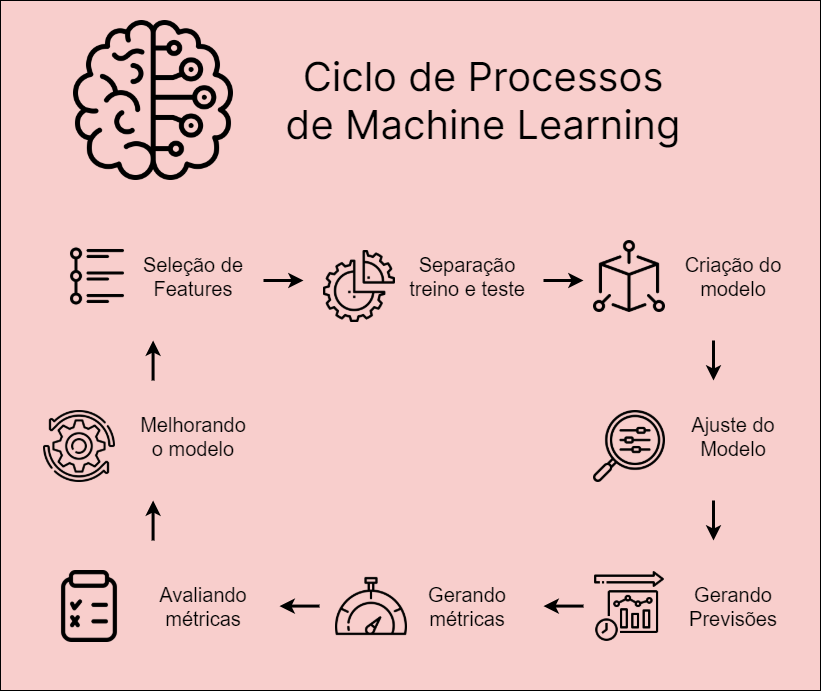

<img src='https://cdn-images-1.medium.com/max/640/1*eeIvlwkMNG1wSmj3FR6M2g.gif'>

## **Preparação dos Dados**

### Variáveis Dummy

In [27]:
dataset.groupBy('customerID').pivot('unit').agg(f.lit(1)).na.fill(0).show()

+---------------+-----------+----+------+
|     customerID|Apartamento|Casa|Outros|
+---------------+-----------+----+------+
|062130-QKYMWGMV|          1|   0|     0|
|630945-AEEUPRXI|          0|   1|     0|
|994985-OZQNHQKH|          1|   0|     0|
|494674-JWXRZIBM|          1|   0|     0|
|458844-UJCRFSRI|          1|   0|     0|
|155284-BRCDAOIQ|          1|   0|     0|
|396742-DUXBHLRU|          1|   0|     0|
|916072-ZJXARAXO|          1|   0|     0|
|943843-BVTWWHRQ|          1|   0|     0|
|193126-MTNIIFQN|          1|   0|     0|
|319762-UXTTQYFS|          1|   0|     0|
|931151-GZCTKADB|          1|   0|     0|
|103840-OFKPFEZJ|          0|   1|     0|
|176885-NNKZRQGM|          0|   1|     0|
|926638-PBYRAZYR|          1|   0|     0|
|744421-IZJWISWB|          1|   0|     0|
|530012-TYGLQMER|          1|   0|     0|
|209407-GTEUOVKR|          1|   0|     0|
|289667-ZPHGFHJH|          1|   0|     0|
|859388-EYTPMKER|          1|   0|     0|
+---------------+-----------+----+

In [28]:
unit = dataset.groupBy('customerID').pivot('unit').agg(f.lit(1)).na.fill(0)
unit.show()

+---------------+-----------+----+------+
|     customerID|Apartamento|Casa|Outros|
+---------------+-----------+----+------+
|062130-QKYMWGMV|          1|   0|     0|
|630945-AEEUPRXI|          0|   1|     0|
|994985-OZQNHQKH|          1|   0|     0|
|494674-JWXRZIBM|          1|   0|     0|
|458844-UJCRFSRI|          1|   0|     0|
|155284-BRCDAOIQ|          1|   0|     0|
|396742-DUXBHLRU|          1|   0|     0|
|916072-ZJXARAXO|          1|   0|     0|
|943843-BVTWWHRQ|          1|   0|     0|
|193126-MTNIIFQN|          1|   0|     0|
|319762-UXTTQYFS|          1|   0|     0|
|931151-GZCTKADB|          1|   0|     0|
|103840-OFKPFEZJ|          0|   1|     0|
|176885-NNKZRQGM|          0|   1|     0|
|926638-PBYRAZYR|          1|   0|     0|
|744421-IZJWISWB|          1|   0|     0|
|530012-TYGLQMER|          1|   0|     0|
|209407-GTEUOVKR|          1|   0|     0|
|289667-ZPHGFHJH|          1|   0|     0|
|859388-EYTPMKER|          1|   0|     0|
+---------------+-----------+----+

In [29]:
zone = dataset.groupBy('customerID').pivot('zone').agg(f.lit(1)).na.fill(0)
zone.show()

+---------------+------------+----------+----------+--------+
|     customerID|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+------------+----------+----------+--------+
|336149-TMGGYSKN|           0|         0|         1|       0|
|846345-JYHIIHQM|           0|         1|         0|       0|
|598128-VUMFFGPB|           0|         0|         0|       1|
|368553-OPCVLPHJ|           0|         1|         0|       0|
|549743-AXHKZBFK|           0|         0|         1|       0|
|812359-OJYBIPJI|           0|         0|         0|       1|
|660235-HZGMOQSM|           0|         0|         1|       0|
|414450-LWZHERNQ|           0|         0|         1|       0|
|060113-BUDVVMLJ|           0|         0|         1|       0|
|002985-MNHDTPVG|           0|         0|         1|       0|
|849580-WTTBUJKK|           0|         1|         0|       0|
|869294-GMGUYRPI|           0|         0|         1|       0|
|744421-IZJWISWB|           0|         0|         1|       0|
|046476-

In [30]:
dataset = dataset.join(unit, 'customerID').join(zone, 'customerID')
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  price|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [31]:
from pyspark.ml.feature import VectorAssembler

In [32]:
dataset = dataset.withColumnRenamed('price', 'label')

In [33]:
X = [
    'bathrooms',
    'bedrooms',
    'floors',
    'parkingSpaces',
    'suites',
    'unitFloor',
    'unitsOnTheFloor',
    'usableAreas',
    'condo',
    'iptu',
    'Apartamento',
    'Casa',
    'Outros',
    'Zona Central',
    'Zona Norte',
    'Zona Oeste',
    'Zona Sul'
]

In [34]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [35]:
dataset.show()

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  label|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|         62|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [36]:
dataset.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- usage: string (nullable = true)
 |-- bathrooms: long (nullable = true)
 |-- bedrooms: long (nullable = true)
 |-- floors: long (nullable = true)
 |-- parkingSpaces: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- unitFloor: long (nullable = true)
 |-- unitsOnTheFloor: long (nullable = true)
 |-- usableAreas: string (nullable = true)
 |-- neighborhood: string (nullable = true)
 |-- zone: string (nullable = true)
 |-- label: double (nullable = false)
 |-- condo: double (nullable = false)
 |-- iptu: double (nullable = false)
 |-- Apartamento: integer (nullable = true)
 |-- Casa: integer (nullable = true)
 |-- Outros: integer (nullable = true)
 |-- Zona Central: integer (nullable = true)
 |-- Zona Norte: integer (nullable = true)
 |-- Zona Oeste: integer (nullable = true)
 |-- Zona Sul: integer (nullable = true)



In [37]:
dataset = dataset.withColumn('usableAreas', dataset['usableAreas'].cast(DoubleType()))

In [38]:
dataset_prep = assembler.transform(dataset).select('features', 'label')

In [39]:
dataset_prep.show()

+--------------------+-------+
|            features|  label|
+--------------------+-------+
|(17,[3,7,8,12,15]...|45000.0|
|(17,[0,1,3,7,8,10...|45000.0|
|(17,[7,8,12,15],[...|50000.0|
|[2.0,3.0,3.0,1.0,...|50000.0|
|(17,[7,12,15],[20...|50000.0|
|(17,[0,1,3,7,10,1...|45336.0|
|(17,[7,12,15],[12...|45000.0|
|(17,[7,12,15],[46...|45000.0|
|(17,[5,7,12,15],[...|50000.0|
|(17,[7,12,15],[12...|50000.0|
|(17,[5,7,8,12,15]...|45000.0|
|[2.0,3.0,20.0,1.0...|45000.0|
|[2.0,3.0,20.0,1.0...|50000.0|
|(17,[0,1,5,7,10,1...|50000.0|
|(17,[7,12,15],[12...|45020.0|
|(17,[7,12,15],[12...|45040.0|
|(17,[7,12,15],[15...|45000.0|
|(17,[0,1,3,7,10,1...|45000.0|
|(17,[7,12,15],[12...|45000.0|
|(17,[7,12,15],[12...|45070.0|
+--------------------+-------+
only showing top 20 rows



## **Exploração dos Dados**

In [40]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [41]:
correlação = Correlation.corr(dataset_prep, 'features').collect()

In [42]:
correlação

[Row(pearson(features)=DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False))]

In [43]:
correlação = Correlation.corr(dataset_prep, 'features').collect()[0][0]

In [44]:
correlação

DenseMatrix(17, 17, [1.0, 0.6659, -0.0446, 0.4876, 0.7529, 0.0076, -0.1074, 0.5981, ..., 0.0088, 0.1803, -0.1833, -0.0165, -0.073, -0.3084, -0.6176, 1.0], False)

In [45]:
correlação.toArray()

array([[ 1.00000000e+00,  6.65910814e-01, -4.45907541e-02,
         4.87590447e-01,  7.52927830e-01,  7.62425469e-03,
        -1.07437445e-01,  5.98072790e-01,  2.00298945e-02,
         1.51023977e-02, -2.75457964e-01,  3.43042378e-01,
        -1.40183420e-01, -9.73678190e-02, -1.62497441e-01,
         2.42345124e-01, -9.87517576e-02],
       [ 6.65910814e-01,  1.00000000e+00, -8.21840063e-02,
         4.67161260e-01,  6.01199220e-01, -7.16195849e-03,
        -1.30814438e-01,  5.63750247e-01,  1.84819307e-02,
         1.36391535e-02, -2.58339018e-01,  3.49962189e-01,
        -2.05607705e-01, -1.23732152e-01, -1.11711865e-01,
         1.63821698e-01, -4.94325200e-02],
       [-4.45907541e-02, -8.21840063e-02,  1.00000000e+00,
        -4.84861921e-02, -4.81062141e-02,  1.20981700e-01,
         7.37717422e-01, -1.03916850e-01,  1.37973623e-02,
         6.68849447e-03,  1.53947015e-01, -1.42089598e-01,
        -5.19462291e-02,  1.26044467e-01, -1.69262936e-02,
        -3.17495417e-02,  1.7

In [46]:
dataframe_correlação = pd.DataFrame(correlação.toArray(), columns=X, index=X)

In [47]:
dataframe_correlação

,bathrooms,bedrooms,floors,parkingSpaces,suites,unitFloor,unitsOnTheFloor,usableAreas,condo,iptu,Apartamento,Casa,Outros,Zona Central,Zona Norte,Zona Oeste,Zona Sul
bathrooms,1.000000,0.665911,-0.044591,0.487590,0.752928,0.007624,-0.107437,0.598073,0.020030,0.015102,-0.275458,0.343042,-0.140183,-0.097368,-0.162497,0.242345,-0.098752
bedrooms,0.665911,1.000000,-0.082184,0.467161,0.601199,-0.007162,-0.130814,0.563750,0.018482,0.013639,-0.258339,0.349962,-0.205608,-0.123732,-0.111712,0.163822,-0.049433
floors,-0.044591,-0.082184,1.000000,-0.048486,-0.048106,0.120982,0.737717,-0.103917,0.013797,0.006688,0.153947,-0.142090,-0.051946,0.126044,-0.016926,-0.031750,0.017402
parkingSpaces,0.487590,0.467161,-0.048486,1.000000,0.484988,0.003768,-0.074527,0.483732,0.018012,0.009721,-0.252746,0.293326,-0.072359,-0.086437,-0.109957,0.267990,-0.178807
suites,0.752928,0.601199,-0.048106,0.484988,1.000000,0.005206,-0.091914,0.577636,0.023461,0.019093,-0.236217,0.282221,-0.088834,-0.084417,-0.230317,0.327546,-0.136398
unitFloor,0.007624,-0.007162,0.120982,0.003768,0.005206,1.000000,0.092359,-0.012748,0.003065,0.001200,0.034674,-0.031403,-0.013275,0.022315,-0.011112,0.007518,-0.004333
unitsOnTheFloor,-0.107437,-0.130814,0.737717,-0.074527,-0.091914,0.092359,1.000000,-0.144222,-0.000554,0.005029,0.147497,-0.137754,-0.045523,0.153639,0.030753,-0.012434,-0.055540
usableAreas,0.598073,0.563750,-0.103917,0.483732,0.577636,-0.012748,-0.144222,1.000000,0.019717,0.014656,-0.482170,0.459136,0.125672,-0.075256,-0.158553,0.192466,-0.051962
condo,0.020030,0.018482,0.013797,0.018012,0.023461,0.003065,-0.000554,0.019717,1.000000,0.226212,0.009105,-0.008624,-0.002495,-0.003553,-0.013453,-0.001055,0.014474
iptu,0.015102,0.013639,0.006688,0.009721,0.019093,0.001200,0.005029,0.014656,0.226212,1.000000,-0.001502,0.002291,-0.001870,-0.002438,-0.008400,-0.000428,0.008835


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

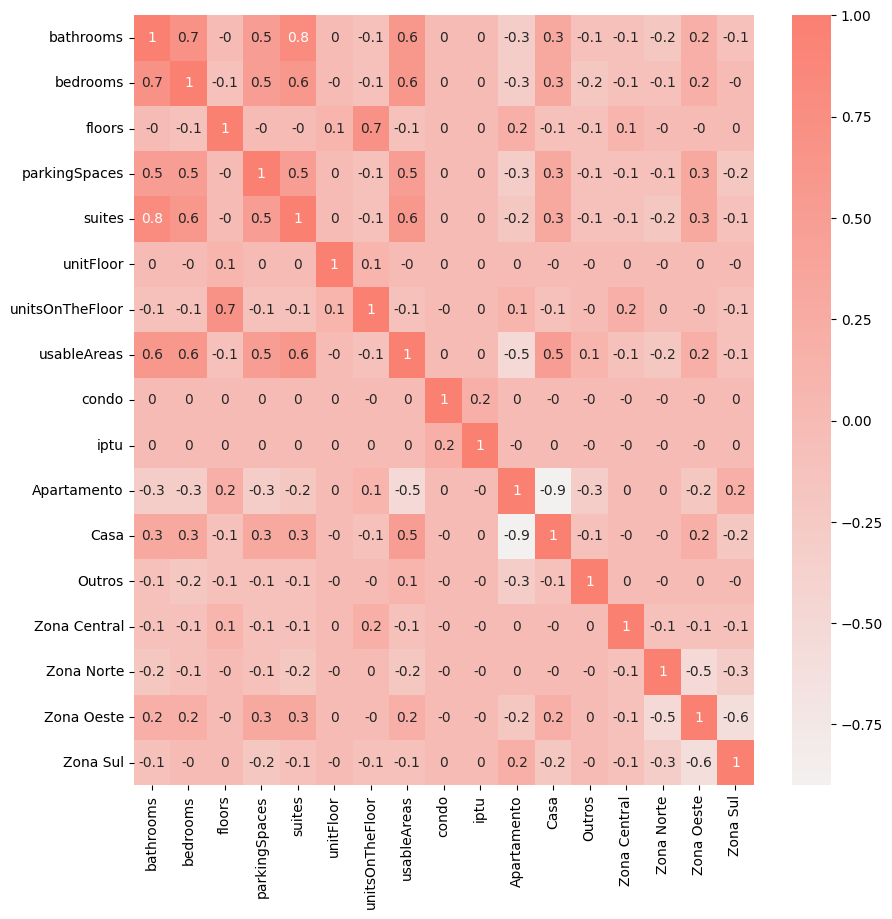

In [49]:
plt.figure(figsize=(10, 10))
paleta=sns.color_palette('light:salmon', as_cmap=True)
sns.heatmap(dataframe_correlação.round(1), annot=True, cmap=paleta)

## **Ajuste e Previsão**

<font size=2>**Documentação:**</font>
<font size=2>[randomSplit](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.randomSplit.html)</font> |
<font size=2>[LinearRegression](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html)</font>

In [50]:
from pyspark.ml.regression import LinearRegression

In [51]:
treino, teste = dataset_prep.randomSplit([0.7, 0.3], seed=101)

In [52]:
treino.count()

48528

In [53]:
teste.count()

20911

In [54]:
lr = LinearRegression()

In [55]:
modelo_lr = lr.fit(treino)

In [56]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [57]:
previsoes_lr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0|443266.04737020144|
|(17,[0,1,2,3,4,5,...|500000.0|1127455.8300462805|
|(17,[0,1,2,3,4,5,...|308615.0|111210.49949889386|
|(17,[0,1,2,3,4,5,...|279000.0|113587.95787719043|
|(17,[0,1,2,3,4,5,...|545000.0|340703.71307873435|
|(17,[0,1,2,3,4,5,...|449000.0|390571.99595798284|
|(17,[0,1,2,3,4,5,...|479000.0| 444003.4297194885|
|(17,[0,1,2,3,4,5,...|420000.0| 720022.1542161054|
|(17,[0,1,2,3,4,5,...|265000.0|519406.05037395435|
|(17,[0,1,2,3,4,5,...|490000.0| 845483.5388437647|
|(17,[0,1,2,3,4,5,...|650000.0| 644931.4982488954|
|(17,[0,1,2,3,4,5,...|379900.0| 448889.3339027724|
|(17,[0,1,2,3,4,5,...|449000.0| 714548.9501108339|
|(17,[0,1,2,3,4,5,...|190000.0| 411726.9411630478|
|(17,[0,1,2,3,4,5,...|896000.0| 597499.4601552959|
|(17,[0,1,2,3,4,5,...|679000.0| 864544.0129262989|
|(17,[0,1,2,3,4,5,...|620000.0|

## **Métricas**

In [58]:
resumo_treino = modelo_lr.summary

In [59]:
resumo_treino.r2

0.6655873678454578

In [60]:
resumo_treino.rootMeanSquaredError

810348.969531623

In [61]:
resumo_teste = modelo_lr.evaluate(teste)

In [62]:
resumo_teste.r2

0.6585207937774393

In [63]:
resumo_teste.rootMeanSquaredError

800525.9696828632

### **Tabela Resumo Regressão Linear**

In [64]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.665587
RMSE: 810348.969532

Dados de Teste
R²: 0.658521
RMSE: 800525.969683


# **Aula 3 - Árvore de Decisão - Regressão**

## **O Modelo**

<img src='https://raw.githubusercontent.com/pedrohcmds/alura_testes/main/Árvore%20de%20Decisão%20-%20Regressão%20(2).gif'>

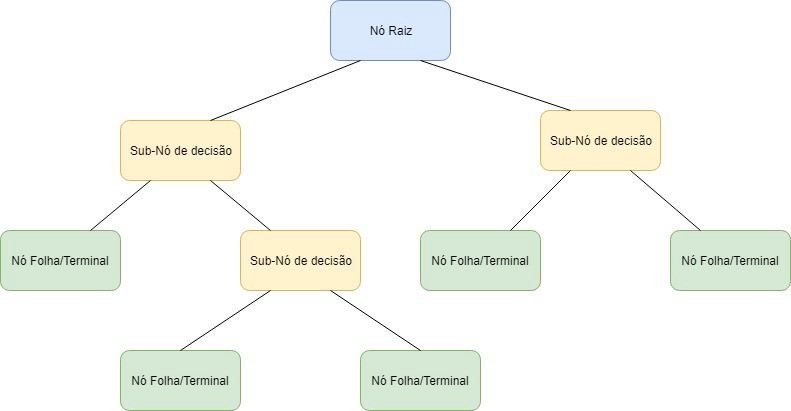

## **Ajuste e Previsão**


<font size=2>**Documentação:**</font>
<font size=2>[DecisionTreeRegressor](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.DecisionTreeRegressor.html)</font>

In [65]:
from pyspark.ml.regression import DecisionTreeRegressor

In [66]:
dtr = DecisionTreeRegressor(seed=101, maxDepth=7)

In [67]:
modelo_dtr = dtr.fit(treino)

In [68]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [69]:
previsoes_dtr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|500000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|308615.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|279000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|545000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|479000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|420000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|265000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|490000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...|650000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...|379900.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|190000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|896000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|679000.0|1158420.7653661144|
|(17,[0,1,2,3,4,5,...|620000.0|

## **Métricas**

<font size=2>**Documentação:**</font>
<font size=2>[RegressionEvaluator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.evaluation.RegressionEvaluator.html)</font>

In [70]:
from pyspark.ml.evaluation import RegressionEvaluator

In [71]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_lr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_lr_treino, {evaluator.metricName: "rmse"} ))

0.6655873678454578
810348.969531623


In [72]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [73]:
previsoes_dtr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 350000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...| 340000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 430000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 600000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 439000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 333000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 948000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...| 459600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 447600.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 360000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...| 407000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...| 310000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|1400000.0|1289301.4891122277|
|(17,[0,1,2,3,4,5,...|1180000.0|1289301.4891122277|
|(17,[0,1,2,3,4,5,...|1299500.0|1158420.7653661144|
|(17,[0,1,2,

In [74]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino
R²: 0.793075
RMSE: 637436.543426

Dados de Teste
R²: 0.773813
RMSE: 651518.489921


# **Aula 4 - Random Forest - Regressão**

## **O Modelo**

### Random Forest

<img src='https://1.bp.blogspot.com/-Ax59WK4DE8w/YK6o9bt_9jI/AAAAAAAAEQA/9KbBf9cdL6kOFkJnU39aUn4m8ydThPenwCLcBGAsYHQ/s0/Random%2BForest%2B03.gif'>

## **Ajuste e Previsão**

<font size=2>**Documentação:**</font>
<font size=2>[RandomForestRegressor](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.RandomForestRegressor.html)</font>

In [75]:
from pyspark.ml.regression import RandomForestRegressor

In [76]:
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)

In [77]:
modelo_rfr = rfr.fit(treino)

In [78]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [79]:
previsoes_dtr_treino.show()

+--------------------+--------+------------------+
|            features|   label|        prediction|
+--------------------+--------+------------------+
|(17,[0,1,2,3,4,5,...|260000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|500000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|308615.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|279000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|545000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|479000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|420000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|265000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|490000.0|  820272.937751004|
|(17,[0,1,2,3,4,5,...|650000.0|  736254.943802521|
|(17,[0,1,2,3,4,5,...|379900.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|449000.0|     445137.460625|
|(17,[0,1,2,3,4,5,...|190000.0| 340855.8044843049|
|(17,[0,1,2,3,4,5,...|896000.0| 553816.2525860447|
|(17,[0,1,2,3,4,5,...|679000.0|1158420.7653661144|
|(17,[0,1,2,3,4,5,...|620000.0|

## **Métricas**

In [80]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.8017561510914318
623922.4426224458


In [81]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [82]:
previsoes_rfr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(17,[0,1,2,3,4,5,...| 199000.0| 350678.0454640939|
|(17,[0,1,2,3,4,5,...| 350000.0| 792518.9735011571|
|(17,[0,1,2,3,4,5,...| 340000.0|479615.50733929937|
|(17,[0,1,2,3,4,5,...| 430000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 600000.0| 526635.5362588142|
|(17,[0,1,2,3,4,5,...| 439000.0| 550795.8732599718|
|(17,[0,1,2,3,4,5,...| 333000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 948000.0| 640247.1517314625|
|(17,[0,1,2,3,4,5,...| 459600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 447600.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 360000.0| 356904.3339549792|
|(17,[0,1,2,3,4,5,...| 407000.0|  492913.652312712|
|(17,[0,1,2,3,4,5,...| 310000.0|412580.35636663495|
|(17,[0,1,2,3,4,5,...|1400000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1180000.0| 1375418.570408164|
|(17,[0,1,2,3,4,5,...|1299500.0|1111896.8209940076|
|(17,[0,1,2,

In [83]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.801756
RMSE: 623922.442622

Dados de Teste
R²: 0.790530
RMSE: 626981.467738


# **Aula 5 - Técnicas de Otimização**

## **Ferramentas**

### Cross Validation

<img src='https://miro.medium.com/max/1400/1*kkMtezwv8qj1t9uG4nw_8g.png'>

## **Árvore de Decisão com Cross Validation**

<font size=2>**Documentação:**</font>
<font size=2>[CrossValidator](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.CrossValidator.html)</font> |
<font size=2>[ParamGridBuilder](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.tuning.ParamGridBuilder.html)</font>

In [84]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [85]:
dtr = DecisionTreeRegressor()

In [92]:
grid = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [2, 5, 7, 10]) \
    .addGrid(dtr.maxBins, [10, 32, 45, 66]) \
    .build()

In [93]:
evaluator = RegressionEvaluator()

In [94]:
dtr_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed = 101
)

In [95]:
modelo_dtr_cv = dtr_cv.fit(treino)

In [96]:
previsoes_dtr_cv_teste = modelo_dtr_cv.transform(teste)

In [97]:
print('Árvore de Decisão')
print('='*30)
print('Sem Cross Validation')
print("="*30)
print('R²: %f' % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print('RMSE: %f' % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print('Com Cross Validation')
print("="*30)
print('R²: %f' % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print('RMSE: %f' % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Árvore de Decisão
Sem Cross Validation
R²: 0.773813
RMSE: 651518.489921

Com Cross Validation
R²: 0.788591
RMSE: 629875.610781


## **Random Forest com Cross Validation**

In [98]:
rfr = RandomForestRegressor()

In [99]:
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30]) \
    .addGrid(rfr.maxDepth, [2, 5, 7, 10]) \
    .addGrid(rfr.maxBins, [10, 32, 45, 66]) \
    .build()

In [100]:
evaluator = RegressionEvaluator()

In [101]:
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed = 101
)

In [102]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [103]:
modelo_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [104]:
print('Random Forest')
print('='*30)
print('Sem Cross Validation')
print("="*3)
print('R²: %f' % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print('RMSE: %f' % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print('Com Cross Validation')
print("="*30)
print('R²: %f' % evaluator.evaluate(modelo_rfr_cv_teste, {evaluator.metricName: "r2"}))
print('RMSE: %f' % evaluator.evaluate(modelo_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest
Sem Cross Validation
===
R²: 0.790530
RMSE: 626981.467738

Com Cross Validation
R²: 0.832235
RMSE: 561104.816257


### **Processos de Machine Learning**
::

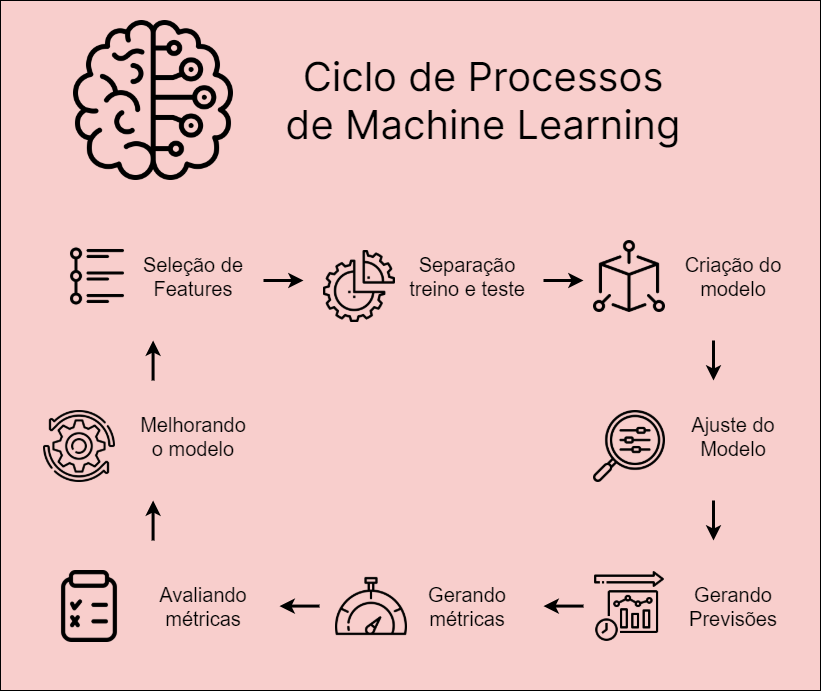

##Prevendo Resultados com o Melhor modelo

In [105]:
dataset.show(15)

+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|     customerID|       unit|      usage|bathrooms|bedrooms|floors|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|        neighborhood|        zone|  label|condo| iptu|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+---------------+-----------+-----------+---------+--------+------+-------------+------+---------+---------------+-----------+--------------------+------------+-------+-----+-----+-----------+----+------+------------+----------+----------+--------+
|775564-BOJSMVON|     Outros|Residencial|        0|       0|     0|            1|     0|        0|              0|       62.0|             Taquara|  Zona Oeste|45000.0|150.0|  0.0|          0|   0|     1|           0|         0|         1|       0|
|660

In [114]:
X

['bathrooms',
 'bedrooms',
 'floors',
 'parkingSpaces',
 'suites',
 'unitFloor',
 'unitsOnTheFloor',
 'usableAreas',
 'condo',
 'iptu',
 'Apartamento',
 'Casa',
 'Outros',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [115]:
# Usando o modelo para prever o valor do imóvel que eu desejo.
novo_imovel = [{
    'bathrooms': 2,
    'bedrooms': 2,
    'floors': 1,
    'parkingSpaces': 1,
    'suites': 0,
    'unitFloor': 0,
    'unitsOnTheFloor': 0,
    'usableAreas': 150,
    'condo': 500,
    'iptu': 0,
    'Apartamento': 0,
    'Casa': 1,
    'Outros': 0,
    'Zona Central': 0,
    'Zona Norte': 0,
    'Zona Oeste': 0,
    'Zona Sul': 1,
    'label': 0
}]

In [116]:
meu_imovel = spark.createDataFrame(novo_imovel)

In [117]:
meu_imovel.show()

+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+
|Apartamento|Casa|Outros|Zona Central|Zona Norte|Zona Oeste|Zona Sul|bathrooms|bedrooms|condo|floors|iptu|label|parkingSpaces|suites|unitFloor|unitsOnTheFloor|usableAreas|
+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+
|          0|   1|     0|           0|         0|         0|       1|        2|       2|  500|     1|   0|    0|            1|     0|        0|              0|        150|
+-----------+----+------+------------+----------+----------+--------+---------+--------+-----+------+----+-----+-------------+------+---------+---------------+-----------+



In [118]:
assembler = VectorAssembler(inputCols = X, outputCol = 'features')

In [119]:
meu_lar_vetorizado = assembler.transform(meu_imovel).select('features', 'label')

In [120]:
meu_lar_vetorizado.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(17,[0,1,2,3,7,8,...|    0|
+--------------------+-----+



In [121]:
modelo_rfr_cv.transform(meu_lar_vetorizado).show()

+--------------------+-----+------------------+
|            features|label|        prediction|
+--------------------+-----+------------------+
|(17,[0,1,2,3,7,8,...|    0|1020032.5412160337|
+--------------------+-----+------------------+

